In [10]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [68]:
!pip3 install pyspark
!pip3 install umap-learn
!pip3 install numba==0.51.2
!pip3 install umap-learn[plot]

In [69]:
# !pip3 install numba==0.51.2
import numba
numba.__version__

'0.51.2'

In [20]:
from pyspark.ml.recommendation import ALSModel
from pyspark.sql import SparkSession
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import umap
import collections
collections.namedtuple("n", [], module=__name__)
import pynndescent
pynndescent.rp_trees.FlatTree.__module__  = "pynndescent.rp_trees"
import umap.plot

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
spark = SparkSession.builder.appName(
    'Qualitative Analysis').getOrCreate()

In [48]:
movies = pd.read_csv("drive/MyDrive/1004/data/movies.csv")

In [49]:
movies[["genre", "genre2", "genre3", "genre4", "genre5", "genre6", "genre7", "genre8", "genre9", "genre10"]] = movies['genres'].str.split("|", expand=True)


In [50]:
del movies["genres"]
movies = movies.replace(["(no genres listed)"], ["No Genre Listed"])

In [51]:
movie_genre = movies[["movieId", "genre"]]
movie_genre

,movieId,genre
0,1,Adventure
1,2,Adventure
2,3,Comedy
3,4,Comedy
4,5,Comedy
...,...,...
58093,193876,No Genre Listed
58094,193878,Comedy
58095,193880,Drama
58096,193882,Adventure


In [52]:
model = ALSModel.load("drive/MyDrive/1004/als_model_full_rank5_reg0.1")

In [53]:
latent_items = model.itemFactors
latent_items.createOrReplaceTempView("latent_items")
latent_items_df = latent_items.toPandas()
latent_items_df
final_df = latent_items_df.merge(movie_genre, left_on='id', right_on='movieId', how='left')

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [54]:
del final_df["movieId"]
final_df

,id,features,genre
0,9,"[0.0, 0.2270389199256897, 0.0, 0.0, 0.36526155...",Action
1,19,"[0.2666953504085541, 0.2944944202899933, 0.523...",Comedy
2,29,"[0.549498975276947, 0.46894240379333496, 0.0, ...",Adventure
3,39,"[0.19927744567394257, 0.6290894746780396, 0.24...",Comedy
4,49,"[0.039421215653419495, 0.06471322476863861, 0....",Drama
...,...,...,...
22817,169666,"[0.008147134445607662, 0.0026004428509622812, ...",Thriller
22818,169756,"[0.06918412446975708, 0.0067845615558326244, 0...",Comedy
22819,169906,"[0.21283870935440063, 0.0, 0.00778538268059492...",Crime
22820,170026,"[0.0060447948053479195, 0.0, 0.000168855345691...",Drama


In [55]:
X = np.vstack(list(final_df.features))
X = StandardScaler().fit_transform(X)
samples = np.random.choice(X.shape[0], 5000, replace=False)

In [56]:
mapper = umap.UMAP(verbose=True).fit(X[samples])
X_embedded = mapper.transform(X[samples])

UMAP( verbose=True)
Tue May 17 17:40:33 2022 Construct fuzzy simplicial set
Tue May 17 17:40:33 2022 Finding Nearest Neighbors
Tue May 17 17:40:33 2022 Building RP forest with 9 trees
Tue May 17 17:40:34 2022 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Tue May 17 17:40:44 2022 Finished Nearest Neighbor Search
Tue May 17 17:40:47 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue May 17 17:41:01 2022 Finished embedding


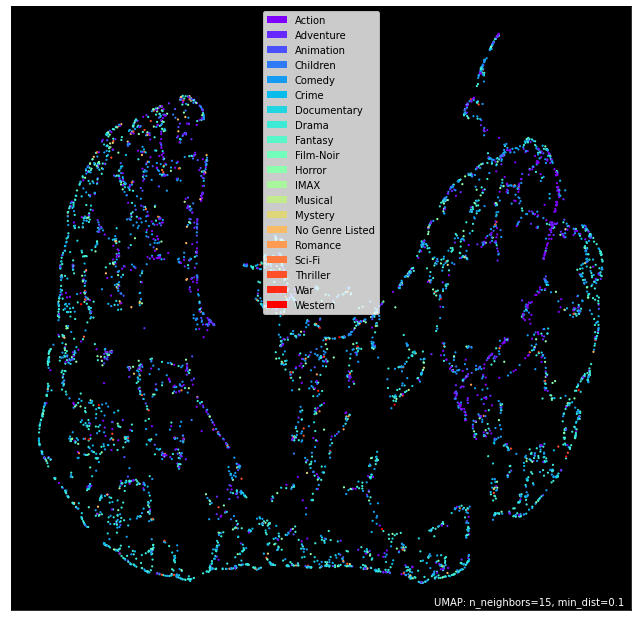

In [57]:
umap.plot.points(mapper, labels=final_df.genre[samples], theme='fire')

In [58]:
latent_users = model.userFactors
latent_users.createOrReplaceTempView("latent_users")
latent_users_df = latent_users.toPandas()
latent_users_df

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


,id,features
0,2,"[0.0, 0.07137956470251083, 0.0, 0.0, 0.0]"
1,12,"[0.0, 0.033157337456941605, 0.0, 0.06618724763..."
2,22,"[0.0, 0.05406034365296364, 0.01699518598616123..."
3,32,"[0.0, 0.0, 0.010022902861237526, 0.22763302922..."
4,42,"[0.16258439421653748, 0.059826821088790894, 0...."
...,...,...
141989,169974,"[0.0970369279384613, 0.0, 0.0, 0.4631544053554..."
141990,169984,"[0.0, 0.028407974168658257, 0.0, 0.0, 0.041840..."
141991,169994,"[0.0, 0.22488529980182648, 0.0, 0.319441825151..."
141992,170004,"[0.09179790318012238, 0.03778163343667984, 0.3..."


In [59]:
X = np.vstack(list(latent_users_df.features))
X = StandardScaler().fit_transform(X)
samples_users = np.random.choice(X.shape[0], 4000, replace=False)

In [60]:
mapper_users = umap.UMAP(verbose=True).fit(X[samples_users])
X_embedded = mapper_users.transform(X[samples_users])

UMAP( verbose=True)
Tue May 17 17:41:07 2022 Construct fuzzy simplicial set
Tue May 17 17:41:15 2022 Finding Nearest Neighbors
Tue May 17 17:41:19 2022 Finished Nearest Neighbor Search
Tue May 17 17:41:19 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Tue May 17 17:41:31 2022 Finished embedding


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


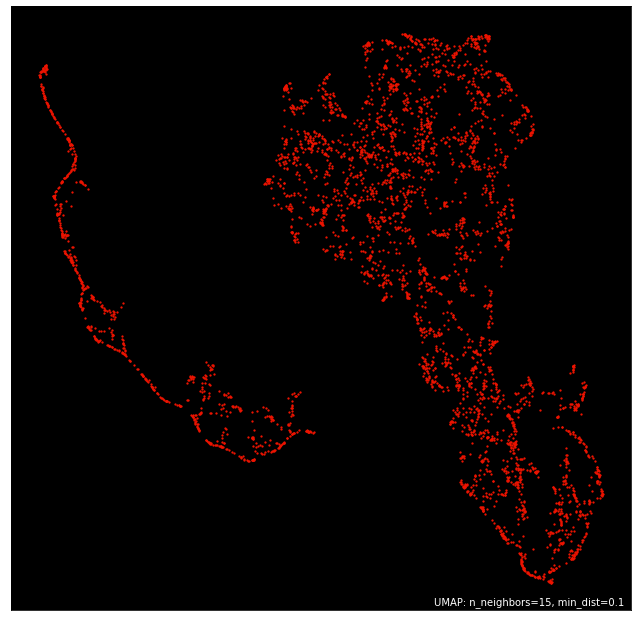

In [61]:
umap.plot.points(mapper_users, theme='fire')